# Reinforcement Learning Programming assignment 1
## K-armed bandit problem
Refer to the assignment [here](prog_assn_1.pdf)
Instructions to run [here](README.md)

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 10-armed bandit testbed
- Simulates the 10-armed bandit problem. 
- Generates 2000 such independent bandits

In [1]:
import numpy as np

# Testbed configuration
n_bandits = 2000
n_arms = 10
rng = np.random.default_rng(0)

# True action values q*(a) ~ N(0,1) for each bandit and arm
true_q = rng.normal(loc=0.0, scale=1.0, size=(n_bandits, n_arms))

def sample_reward(bandit_idx, action_idx):
    """Sample reward r ~ N(q*(a), 1) for one bandit and one action."""
    mean = true_q[bandit_idx, action_idx]
    return rng.normal(loc=mean, scale=1.0)

# Vectorized reward sampler for a batch of bandits/actions
def sample_reward_batch(bandit_indices, action_indices):
    """
    bandit_indices: shape (B,)
    action_indices: shape (B,)
    returns rewards: shape (B,)
    """
    means = true_q[bandit_indices, action_indices]
    return rng.normal(loc=means, scale=1.0)

### Greedy strategy
Let's run the greedy algorithm for choosing the best arm on this testbed.

In [4]:
def run_greedy(true_q, n_steps, rng):
    n_bandits, n_arms = true_q.shape
    Q = np.zeros((n_bandits, n_arms), dtype=float)
    N = np.zeros((n_bandits, n_arms), dtype=int)

    optimal_actions = np.argmax(true_q, axis=1)
    avg_rewards = np.zeros(n_steps)
    pct_optimal = np.zeros(n_steps)

    for t in range(n_steps):
        # Greedy action with random tie-breaking
        actions = np.argmax(Q + rng.random(Q.shape) * 1e-8, axis=1)

        rewards = rng.normal(loc=true_q[np.arange(n_bandits), actions], scale=1.0)

        idx = (np.arange(n_bandits), actions)
        N[idx] += 1
        Q[idx] += (rewards - Q[idx]) / N[idx]

        avg_rewards[t] = rewards.mean()
        pct_optimal[t] = (actions == optimal_actions).mean() * 100.0

    return avg_rewards, pct_optimal

Run the algorithm

In [5]:
n_steps = 1000
avg_reward_greedy, pct_opt_greedy = run_greedy(true_q, n_steps, rng)

Plot the curves

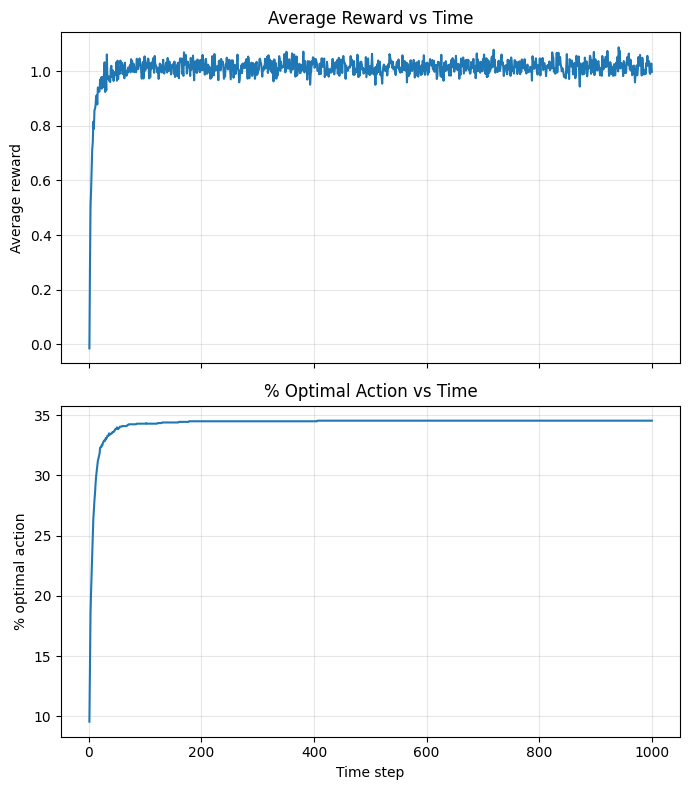

In [6]:
steps = np.arange(1, n_steps + 1)

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

axes[0].plot(steps, avg_reward_greedy, label="Greedy")
axes[0].set_title("Average Reward vs Time")
axes[0].set_ylabel("Average reward")
axes[0].grid(True, alpha=0.3)

axes[1].plot(steps, pct_opt_greedy, label="% Optimal")
axes[1].set_title("% Optimal Action vs Time")
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("% optimal action")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Epsilon greedy versions

In [7]:
def run_epsilon_greedy(true_q, n_steps, eps, rng):
    n_bandits, n_arms = true_q.shape
    Q = np.zeros((n_bandits, n_arms), dtype=float)
    N = np.zeros((n_bandits, n_arms), dtype=int)

    optimal_actions = np.argmax(true_q, axis=1)
    avg_rewards = np.zeros(n_steps)
    pct_optimal = np.zeros(n_steps)

    for t in range(n_steps):
        explore = rng.random(n_bandits) < eps

        # Greedy with random tie-breaking
        greedy_actions = np.argmax(Q + rng.random(Q.shape) * 1e-8, axis=1)
        random_actions = rng.integers(0, n_arms, size=n_bandits)

        actions = np.where(explore, random_actions, greedy_actions)
        rewards = rng.normal(loc=true_q[np.arange(n_bandits), actions], scale=1.0)

        idx = (np.arange(n_bandits), actions)
        N[idx] += 1
        Q[idx] += (rewards - Q[idx]) / N[idx]

        avg_rewards[t] = rewards.mean()
        pct_optimal[t] = (actions == optimal_actions).mean() * 100.0

    return avg_rewards, pct_optimal

Run for all 3 -> greedy (eps = 0), eps = 0.1, eps = 0.01

In [8]:
n_steps = 1000
eps_list = [0.0, 0.1, 0.01]
results = {}

for eps in eps_list:
    avg_r, pct_opt = run_epsilon_greedy(true_q, n_steps, eps, rng)
    results[eps] = (avg_r, pct_opt)

Plots

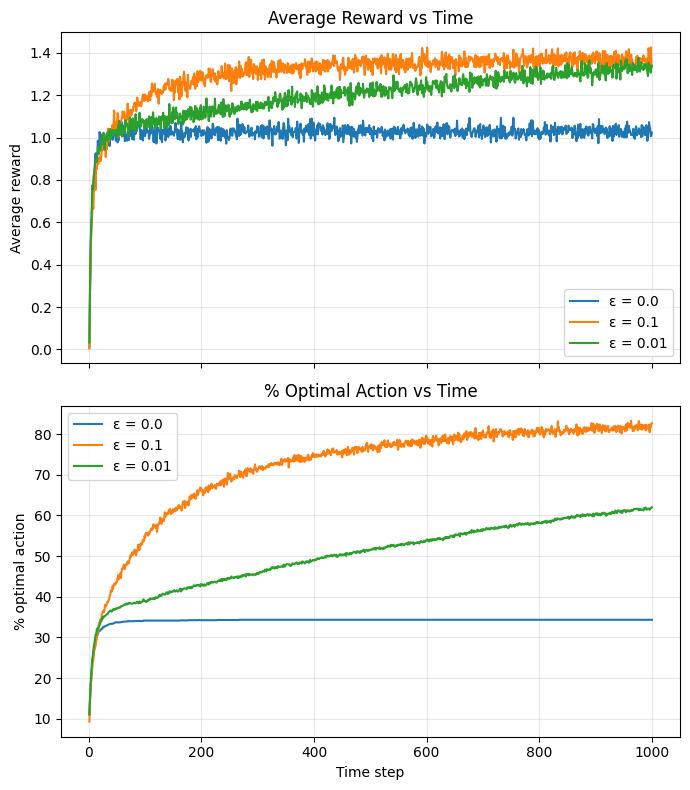

In [9]:
steps = np.arange(1, n_steps + 1)
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

for eps in eps_list:
    avg_r, pct_opt = results[eps]
    label = f"ε = {eps}"
    axes[0].plot(steps, avg_r, label=label)
    axes[1].plot(steps, pct_opt, label=label)

axes[0].set_title("Average Reward vs Time")
axes[0].set_ylabel("Average reward")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].set_title("% Optimal Action vs Time")
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("% optimal action")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

### UCB algorithm
Let's now run the UCB algorithm with the formula provided in the PDF. 

In [12]:
def run_ucb(true_q, n_steps, c, rng):
    n_bandits, n_arms = true_q.shape
    Q = np.zeros((n_bandits, n_arms), dtype=float)
    N = np.zeros((n_bandits, n_arms), dtype=int)

    optimal_actions = np.argmax(true_q, axis=1)
    avg_rewards = np.zeros(n_steps)
    pct_optimal = np.zeros(n_steps)

    for t in range(1, n_steps + 1):
        # Avoid divide-by-zero by using max(N, 1)
        bonus = c * np.sqrt(np.log(t) / np.maximum(N, 1))
        ucb = Q + bonus
        ucb[N == 0] = np.inf  # force trying unvisited arms

        actions = np.argmax(ucb + rng.random(Q.shape) * 1e-8, axis=1)
        rewards = rng.normal(loc=true_q[np.arange(n_bandits), actions], scale=1.0)

        idx = (np.arange(n_bandits), actions)
        N[idx] += 1
        Q[idx] += (rewards - Q[idx]) / N[idx]

        avg_rewards[t - 1] = rewards.mean()
        pct_optimal[t - 1] = (actions == optimal_actions).mean() * 100.0

    return avg_rewards, pct_optimal


Running the UCB and epsilon-greedy (eps=0.1)

In [13]:
n_steps = 1000
eps = 0.1
c = np.sqrt(2)

avg_r_eps, pct_opt_eps = run_epsilon_greedy(true_q, n_steps, eps, rng)
avg_r_ucb, pct_opt_ucb = run_ucb(true_q, n_steps, c, rng)

Comparison

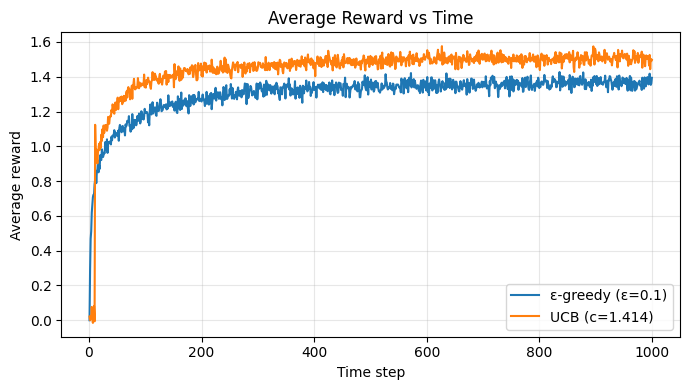

In [14]:
steps = np.arange(1, n_steps + 1)
plt.figure(figsize=(7,4))
plt.plot(steps, avg_r_eps, label="ε-greedy (ε=0.1)")
plt.plot(steps, avg_r_ucb, label=f"UCB (c={c:.3f})")
plt.title("Average Reward vs Time")
plt.xlabel("Time step")
plt.ylabel("Average reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

UCB with varying c values

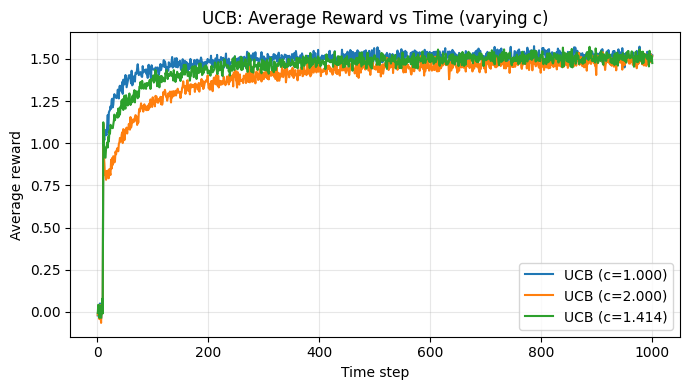

In [15]:
c_values = [1.0, 2.0, np.sqrt(2)]
n_steps = 1000
steps = np.arange(1, n_steps + 1)

plt.figure(figsize=(7,4))
for c in c_values:
    avg_r_ucb, _ = run_ucb(true_q, n_steps, c, rng)
    plt.plot(steps, avg_r_ucb, label=f"UCB (c={c:.3f})")

plt.title("UCB: Average Reward vs Time (varying c)")
plt.xlabel("Time step")
plt.ylabel("Average reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Experimenting with a large testbed (10k arms, number of bandits between 200-500 (choosing 300 for the experiments))

Settings for the large testbed

In [16]:
n_bandits = 300         
n_arms = 10_000
n_steps = 1000
rng = np.random.default_rng(0)

True action values

In [17]:
true_q_large = rng.normal(loc=0.0, scale=1.0, size=(n_bandits, n_arms))

Epsilon-greedy experiments

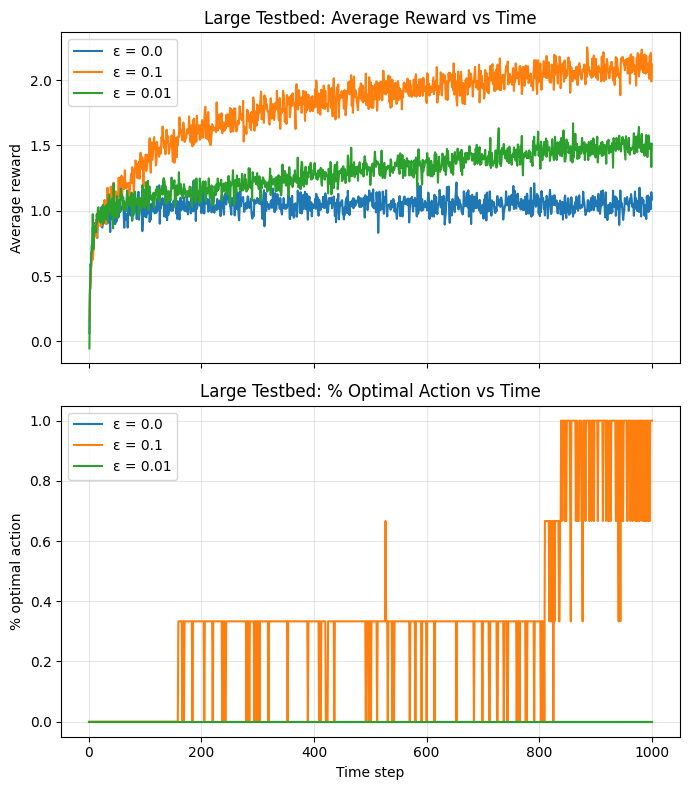

In [18]:
eps_list = [0.0, 0.1, 0.01]
results_eps = {}

for eps in eps_list:
    avg_r, pct_opt = run_epsilon_greedy(true_q_large, n_steps, eps, rng)
    results_eps[eps] = (avg_r, pct_opt)

steps = np.arange(1, n_steps + 1)

fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
for eps in eps_list:
    avg_r, pct_opt = results_eps[eps]
    axes[0].plot(steps, avg_r, label=f"ε = {eps}")
    axes[1].plot(steps, pct_opt, label=f"ε = {eps}")

axes[0].set_title("Large Testbed: Average Reward vs Time")
axes[0].set_ylabel("Average reward")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].set_title("Large Testbed: % Optimal Action vs Time")
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("% optimal action")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

UCB vs epsilon-greedy

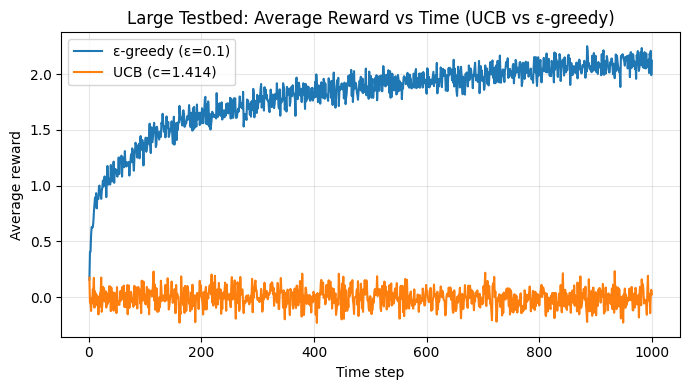

In [19]:
c = np.sqrt(2)
avg_r_ucb, _ = run_ucb(true_q_large, n_steps, c, rng)
avg_r_eps, _ = results_eps[0.1]

plt.figure(figsize=(7, 4))
plt.plot(steps, avg_r_eps, label="ε-greedy (ε=0.1)")
plt.plot(steps, avg_r_ucb, label=f"UCB (c={c:.3f})")
plt.title("Large Testbed: Average Reward vs Time (UCB vs ε-greedy)")
plt.xlabel("Time step")
plt.ylabel("Average reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

UCB with varying c

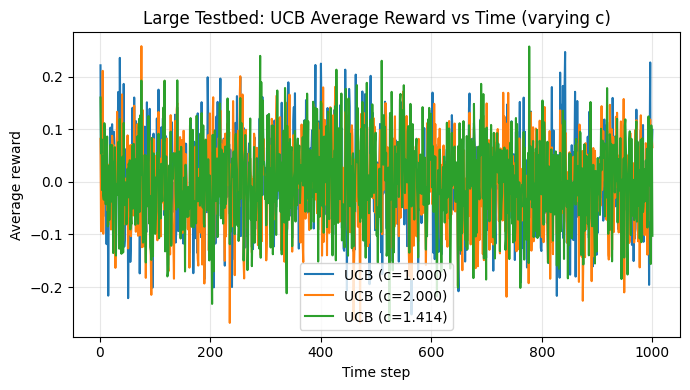

In [20]:
c_values = [1.0, 2.0, np.sqrt(2)]
plt.figure(figsize=(7, 4))
for c in c_values:
    avg_r_ucb, _ = run_ucb(true_q_large, n_steps, c, rng)
    plt.plot(steps, avg_r_ucb, label=f"UCB (c={c:.3f})")

plt.title("Large Testbed: UCB Average Reward vs Time (varying c)")
plt.xlabel("Time step")
plt.ylabel("Average reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()